# Multi-layered peceptron with gradient descent under Pytorch without using Pytorch maximize function for hyperparameters 

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import pandas as pd

### Import the dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)  # Les caractéristiques commencent à la colonne 1
        # Normalisation
        self.X /= 255
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)     # La première colonne est la cible
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
epochs = 50

In [3]:
training_data = CustomDataset('../../data/sign_mnist_train.csv')
testing_data = CustomDataset('../../data/sign_mnist_test.csv')

train_loader = DataLoader(training_data, batch_size=32, shuffle=True,)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False,)



### Init the weights

In [4]:
## Init weights
# 784 because there is 784 pixels in each image
# 25 because there is 25 possible outputs : 0,1,2,3,4,5,6,7,8,9,...,25
# Each pixel is linked to 25 outputs where each link is a weight to optimize\
# <=> Each class is linked to 784 pixel where each link is a weight to optimize
weights = torch.randn(784, 25, requires_grad=True)


### Compute the accuracy on the test set


In [5]:
def test(weights, test_loader):
    test_size = len(test_loader.dataset)
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        #print(batch_idx, data.shape, target.shape)
        # data = data.view((-1, 28*28)) already done in the dataset
        #print(batch_idx, data.shape, target.shape)

        outputs = torch.matmul(data, weights)
        softmax = F.softmax(outputs, dim=1)
        pred = softmax.argmax(dim=1, keepdim=True)
        n_correct = pred.eq(target.view_as(pred)).sum().item()
        correct += n_correct

    acc = correct / test_size
    print(" Accuracy on test set", acc)
    return

test(weights, test_loader)

 Accuracy on test set 0.04419966536530954


### Train the model

In [6]:
for epoch in range(epochs):
    it = 1 # we chose 1 and not 0 because taht can create problem with the modulo
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Be sure to start the loop with zeros grad
        if weights.grad is not None:
            weights.grad.zero_()
        
        # data = data.view((-1, 28*28)) already done in the dataset
        outputs = torch.matmul(data, weights)

        log_softmax = F.log_softmax(outputs, dim=1)   # log has better convergence properties
        
        loss = F.nll_loss(log_softmax, targets)    # nll_loss because we want to minimize the negative log likelihood (Gradient descent)
        
        print("\rLoss shape: {}".format(loss), end="")
        
        # Compute the gradients for each variables
        loss.backward()
        
        with torch.no_grad():
            weights -= 0.1*weights.grad
            
        it += 1
        if it % 100 == 0:
            test(weights, test_loader)
            
        if it > 5000:
            break

Loss shape: 5.177018642425537 Accuracy on test set 0.10345789180145008
Loss shape: 5.5570988655090335 Accuracy on test set 0.13190184049079753
Loss shape: 4.3229212760925298 Accuracy on test set 0.18558282208588958
Loss shape: 3.5391714572906494 Accuracy on test set 0.19311210262130507
Loss shape: 4.023074626922607 Accuracy on test set 0.2691020635805912
Loss shape: 2.457159996032715 Accuracy on test set 0.30577244841048523
Loss shape: 2.880488634109497 Accuracy on test set 0.3099553820412716
Loss shape: 2.7475171089172363 Accuracy on test set 0.3414668153931958
Loss shape: 2.7834656238555916 Accuracy on test set 0.3630786391522588
Loss shape: 2.4642181396484375 Accuracy on test set 0.38162297824874514
Loss shape: 2.2961087226867676 Accuracy on test set 0.37214166201896265
Loss shape: 2.8648900985717773 Accuracy on test set 0.39598438371444505
Loss shape: 2.2406008243560798 Accuracy on test set 0.4205242610150586
Loss shape: 1.5588042736053467 Accuracy on test set 0.3877579475738985
Lo

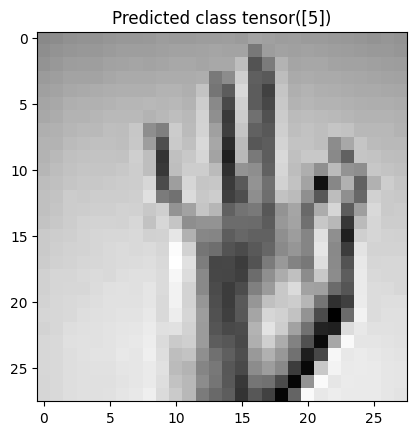

In [8]:
import matplotlib.pyplot as plt

batch_idx, (data, target) = next(enumerate(test_loader))
#data = data.view((-1, 28*28))

outputs = torch.matmul(data, weights)
softmax = F.softmax(outputs, dim=1)
pred = softmax.argmax(dim=1, keepdim=True)

plt.imshow(data[1].view(28, 28), cmap="gray") # *255 isn't usefull beacause of cmap="gray"
plt.title("Predicted class {}".format(pred[1]))
plt.show()